# CNN using Tensorflow
## To classify face_images: wearing_hat and not_wearing_hat
- Dataset: 1900 178px x 218px images (1000 - not_wearing_hat, 900 - wearing_hat)<br>
- Saved model file: hat_classifier_2_97_new.h5 (Prev versions: hat_classifier_2_97_old.h5 and hat_classifier_2.keras)<br>
- Test accuracy: 97.1%<br>

### Imports, functions and constants

In [1]:
# Import libraries

import tensorflow as tf
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Set random seed for reproducibility
# tf.random.set_seed(42)

In [3]:
# Define the custom preprocessing function to crop images to a square ratio
# Crop a square from the center of the image
def crop_to_square(image):
    width, height = image.shape[1], image.shape[0]
    new_width = new_height = min(width, height)
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    # Crop the array by selecting a subset of rows and columns
    image = image[int(top):int(bottom), int(left):int(right)]
    return image

def crop_to_square_for_img(image):
    width, height = image.size
    new_width = new_height = min(width, height)
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    # Crop the image file
    image = image.crop((left, top, right, bottom))
    
    return image

In [4]:
image_size = (178, 218)
data_dir = 'data'

### Data loading and pre-processing

In [5]:
# Get the list of files and labels
file_paths = []
labels = []

for class_label in os.listdir(data_dir):
    # Skip if file is not a directory
    if not os.path.isdir(os.path.join(data_dir, class_label)):
        continue
    class_path = os.path.join(data_dir, class_label)
    
    # Add only jpg files
    class_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.lower().endswith('.jpg')]
    
    # Set label based on class
    # if class_label == 'wearing_hat':
    #     class_label = 1
    # elif class_label == 'not_wearing_hat':
    #     class_label = 0
    # else:
    #     # Handle other classes if needed
    #     continue
    
    file_paths.extend(class_files)
    labels.extend([class_label] * len(class_files))

In [6]:
print(len(file_paths), len(labels))

1900 1900


In [7]:
print(labels[0:-5])

['wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_

### Data splitting

In [8]:
# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25)

In [9]:
print(len(train_paths), len(train_labels))
print(len(val_paths), len(val_labels))

1140 1140
380 380


In [10]:
# Print 5 file paths and labels randomly
print(train_paths[0:5])
print(train_labels[0:5])

['data/not_wearing_hat/185662.jpg', 'data/wearing_hat/180182.jpg', 'data/wearing_hat/008090.jpg', 'data/wearing_hat/157368.jpg', 'data/wearing_hat/138279.jpg']
['not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat']


In [11]:
# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=crop_to_square)
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=crop_to_square)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=crop_to_square)

# Define batch size
batch_size = 32

In [12]:
train_labels = list(train_labels)

train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
train_df['class'] = list(train_labels)
print(type(train_df['class']))

<class 'pandas.core.series.Series'>


In [13]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(pd.DataFrame({'filename': train_paths, 'class': train_labels}), 
                                                    target_size=(178, 178),
                                                    batch_size=batch_size, 
                                                    class_mode='binary'
                                                    )

# Validation data generator
val_generator = val_datagen.flow_from_dataframe(pd.DataFrame({'filename': val_paths, 'class': val_labels}), 
                                                target_size=(178, 178),
                                                batch_size=batch_size, 
                                                class_mode='binary' 
                                                )

# Test data generator
test_generator = test_datagen.flow_from_dataframe(pd.DataFrame({'filename': test_paths, 'class': test_labels}), 
                                                  target_size=(178, 178),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode=None
                                                 )

Found 1140 validated image filenames belonging to 2 classes.
Found 380 validated image filenames belonging to 2 classes.
Found 380 validated image filenames.


In [14]:
print(train_generator.filenames)

['data/not_wearing_hat/185662.jpg', 'data/wearing_hat/180182.jpg', 'data/wearing_hat/008090.jpg', 'data/wearing_hat/157368.jpg', 'data/wearing_hat/138279.jpg', 'data/wearing_hat/069903.jpg', 'data/not_wearing_hat/158563.jpg', 'data/wearing_hat/130616.jpg', 'data/not_wearing_hat/090700.jpg', 'data/wearing_hat/199371.jpg', 'data/wearing_hat/093840.jpg', 'data/wearing_hat/066491.jpg', 'data/not_wearing_hat/135856.jpg', 'data/not_wearing_hat/005681.jpg', 'data/not_wearing_hat/055682.jpg', 'data/not_wearing_hat/088653.jpg', 'data/wearing_hat/037624.jpg', 'data/wearing_hat/048290.jpg', 'data/not_wearing_hat/194463.jpg', 'data/wearing_hat/140176.jpg', 'data/not_wearing_hat/034151.jpg', 'data/wearing_hat/162318.jpg', 'data/wearing_hat/199776.jpg', 'data/not_wearing_hat/021419.jpg', 'data/wearing_hat/025860.jpg', 'data/not_wearing_hat/200224.jpg', 'data/wearing_hat/191197.jpg', 'data/not_wearing_hat/139404.jpg', 'data/wearing_hat/094586.jpg', 'data/not_wearing_hat/174002.jpg', 'data/wearing_hat

### CNN model for binary classification

In [15]:

# Define the CNN architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(178, 178, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

2023-10-01 00:14:49.904308: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-01 00:14:49.904331: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-01 00:14:49.904336: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-01 00:14:49.904370: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-01 00:14:49.904386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 88, 88, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 43, 43, 64)        0

In [16]:

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


2023-10-01 00:14:51.299233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.2765 - accuracy: 0.4947

2023-10-01 00:15:00.107871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 11s 197ms/step - loss: 1.2765 - accuracy: 0.4947 - val_loss: 0.6921 - val_accuracy: 0.5395
Epoch 2/10
36/36 [==============================] - 2s 53ms/step - loss: 0.6789 - accuracy: 0.6149 - val_loss: 0.5861 - val_accuracy: 0.7342
Epoch 3/10
36/36 [==============================] - 2s 53ms/step - loss: 0.3453 - accuracy: 0.8456 - val_loss: 0.2496 - val_accuracy: 0.9079
Epoch 4/10
36/36 [==============================] - 2s 53ms/step - loss: 0.2542 - accuracy: 0.9061 - val_loss: 0.2388 - val_accuracy: 0.9289
Epoch 5/10
36/36 [==============================] - 2s 54ms/step - loss: 0.1828 - accuracy: 0.9404 - val_loss: 0.1939 - val_accuracy: 0.9474
Epoch 6/10
36/36 [==============================] - 2s 53ms/step - loss: 0.1639 - accuracy: 0.9482 - val_loss: 0.1479 - val_accuracy: 0.9526
Epoch 7/10
36/36 [==============================] - 2s 53ms/step - loss: 0.1149 - accuracy: 0.9605 - val_loss: 0.1689 - val_accuracy: 0.9500
Epoch 8/10
36/36 [====

### Visualising the datasets

In [17]:

true_labels = test_labels
print(true_labels)

['wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'weari

In [18]:
# if true_labels == 'wearing_hat' then change it to 1
true_label_ints = [1 if x == 'wearing_hat' else 0 for x in true_labels]

print(true_label_ints)

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 

In [19]:
print(test_generator.filenames)

['data/wearing_hat/054916.jpg', 'data/not_wearing_hat/062215.jpg', 'data/wearing_hat/055339.jpg', 'data/wearing_hat/153856.jpg', 'data/wearing_hat/134195.jpg', 'data/not_wearing_hat/156012.jpg', 'data/wearing_hat/124486.jpg', 'data/wearing_hat/142461.jpg', 'data/not_wearing_hat/126506.jpg', 'data/wearing_hat/126083.jpg', 'data/not_wearing_hat/064211.jpg', 'data/wearing_hat/045346.jpg', 'data/wearing_hat/042441.jpg', 'data/not_wearing_hat/015437.jpg', 'data/wearing_hat/074232.jpg', 'data/wearing_hat/030149.jpg', 'data/wearing_hat/084047.jpg', 'data/wearing_hat/005112.jpg', 'data/wearing_hat/156419.jpg', 'data/wearing_hat/060469.jpg', 'data/wearing_hat/043556.jpg', 'data/not_wearing_hat/071764.jpg', 'data/not_wearing_hat/081673.jpg', 'data/wearing_hat/015012.jpg', 'data/wearing_hat/127736.jpg', 'data/wearing_hat/012677.jpg', 'data/not_wearing_hat/055470.jpg', 'data/not_wearing_hat/174872.jpg', 'data/not_wearing_hat/071966.jpg', 'data/wearing_hat/118403.jpg', 'data/not_wearing_hat/134883.

In [20]:
print(train_generator.classes)

[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 

In [21]:
test_generator.classes = true_label_ints
print(test_generator.classes)
print(test_generator.filenames)

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 

In [22]:
test_generator.class_indices = {'not_wearing_hat': 0, 'wearing_hat': 1}

In [23]:
print(train_generator.classes)

[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 

### Model testing and predictions

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f'Test Accuracy: {test_accuracy}')

2023-10-01 00:15:20.060885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 - 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - 313ms/epoch - 26ms/step
Test Accuracy: 0.0


In [25]:
# Make predictions
predictions = model.predict(test_generator)
print(predictions)


2023-10-01 00:15:20.411134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 38ms/step
[[2.07876280e-01]
 [1.05012178e-01]
 [9.92751837e-01]
 [9.51133966e-01]
 [9.98069704e-01]
 [8.69955402e-03]
 [9.99570668e-01]
 [9.99985695e-01]
 [3.43473032e-02]
 [9.98763561e-01]
 [7.09555894e-02]
 [9.98682082e-01]
 [9.82644379e-01]
 [1.88448559e-02]
 [8.91284287e-01]
 [9.92325068e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [4.51231271e-01]
 [9.99909759e-01]
 [9.70447600e-01]
 [1.74222197e-02]
 [1.41019478e-01]
 [9.49710667e-01]
 [9.50068951e-01]
 [1.00000000e+00]
 [3.56087089e-03]
 [2.78388802e-02]
 [2.40216311e-02]
 [8.06560636e-01]
 [1.71869285e-02]
 [9.99965191e-01]
 [6.86966777e-01]
 [8.32782984e-01]
 [2.30517071e-05]
 [3.25431116e-02]
 [6.86265454e-02]
 [2.12565181e-03]
 [1.42604679e-01]
 [1.23105468e-02]
 [7.86392033e-01]
 [5.21545019e-03]
 [1.00000000e+00]
 [1.94198044e-03]
 [6.28161896e-03]
 [4.09400382e-05]
 [1.98768705e-01]
 [2.42722854e-02]
 [4.36951414e-05]
 [7.00326040e-02]
 [4.17188480e-02]
 [4.25538805e-04]
 [9.999893

In [26]:
predicted_labels = np.round(predictions).flatten()  # Assuming a sigmoid activation in the output layer

In [27]:
print(true_labels)

['wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'weari

In [28]:
print(predicted_labels)

[0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.

In [29]:
predicted_labels = ['wearing_hat' if x == 1 else 'not_wearing_hat' for x in predicted_labels]

print(predicted_labels)

['not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wear

In [30]:
# Save the model
model.save('hat_classifier_2.h5')
# model.save('hat_classifier_2.keras')

/Users/sandulrenuja/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Visualizing the results

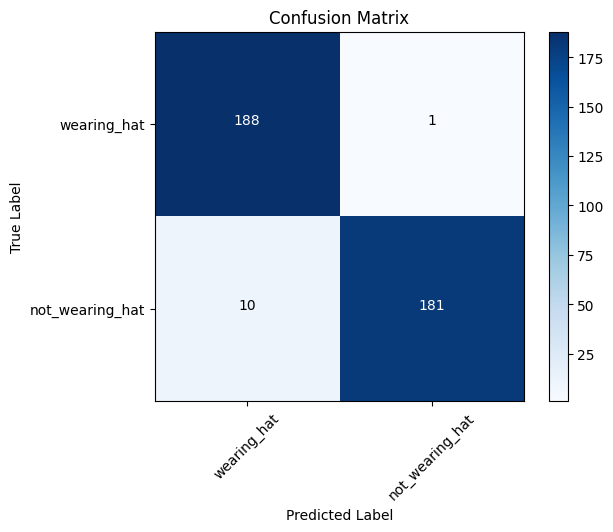

                 precision    recall  f1-score   support

not_wearing_hat       0.95      0.99      0.97       189
    wearing_hat       0.99      0.95      0.97       191

       accuracy                           0.97       380
      macro avg       0.97      0.97      0.97       380
   weighted avg       0.97      0.97      0.97       380



In [31]:
# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Define the class labels
class_labels = ["wearing_hat", "not_wearing_hat"]

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add cell values to the plot
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Set custom axis labels
tick_marks = range(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels))

In [32]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


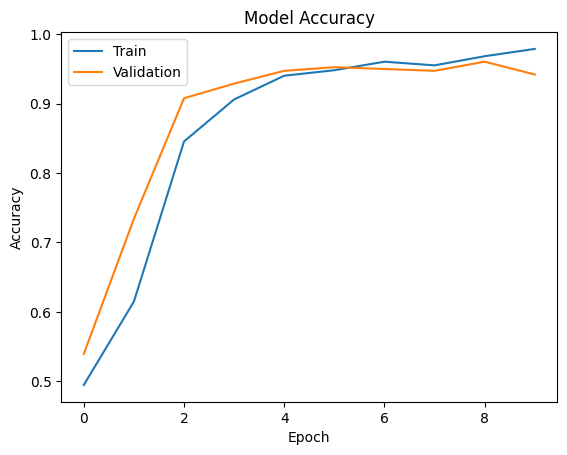

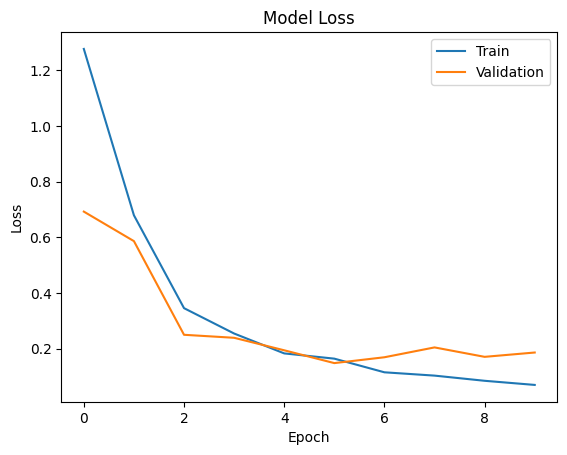

In [33]:

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Import saved model and test on real-world data

In [89]:
# Load model from keras file
model = tf.keras.models.load_model('hat_classifier_2_97_new.h5')
# model = tf.keras.models.load_model('hat_classifier_2.keras', compile=False)

# Compile the model with the Adam optimizer
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
test_generator = test_datagen.flow_from_dataframe(pd.DataFrame({'filename': test_paths, 'class': test_labels}), 
                                                  target_size=(178, 178),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='binary'
                                                 )

Found 380 validated image filenames belonging to 2 classes.


In [36]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f'Test Accuracy: {test_accuracy}')


2023-10-01 00:15:21.916380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 - 2s - loss: 0.1296 - accuracy: 0.9711 - 2s/epoch - 169ms/step
Test Accuracy: 0.9710526466369629


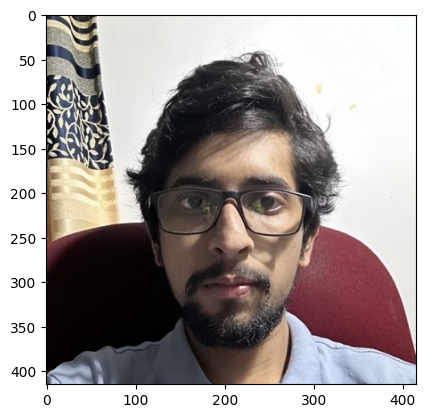

In [90]:
# Predict on a single image
# Load the image and crop to a square
image = tf.keras.preprocessing.image.load_img('real_world/nocap-sr-1.jpeg')
image = crop_to_square_for_img(image)

# Show the image using matplotlib
plt.imshow(image)

In [92]:

# Resize the image to the target size of 178 x 178
image = image.resize((178, 178))

# Convert the image to a numpy array
input_arr = tf.keras.preprocessing.image.img_to_array(image)

# Add another dimension (since Keras expects a list of images)
input_arr = np.array([input_arr])

# Make predictions
predictions = model.predict(input_arr)
print(predictions)
predicted_labels = np.round(predictions).flatten()  # Assuming a sigmoid activation in the output layer
print(predicted_labels)

if predicted_labels[0] == 1.0 :
    print('The person is wearing a hat')
else:
    print('The person is not wearing a hat')

1/1 [==============================] - 0s 15ms/step
[[0.]]
[0.]
The person is not wearing a hat


In [39]:
test_generator = test_datagen.flow_from_dataframe(pd.DataFrame({'filename': test_paths, 'class': test_labels}), 
                                                  target_size=(178, 178),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='binary'
                                                 )

Found 380 validated image filenames belonging to 2 classes.


In [40]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f'Test Accuracy: {test_accuracy}')

12/12 - 0s - loss: 0.1296 - accuracy: 0.9711 - 238ms/epoch - 20ms/step
Test Accuracy: 0.9710526466369629
